# Get combined model results 

In [ ]:
import logging
tf.get_logger().setLevel(logging.ERROR)

## Load data

In [27]:
import os
import sys
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

from AChEi_experiment_helper import load_data, data_scaling, get_model_setup_params, get_model_compile_params, get_dataset_params, setup_callback_paths, get_dense_model, get_attention_model, get_attentionwFW_model, file_updater, model_eval

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.keras.backend.set_floatx('float32')

# Load data
r = load_data()
valid_features = r['valid_features']
valid_target = r['valid_target']
valid_Fweights = r['valid_Fweights']




In [135]:
# Helper functions
def get_model_paths(model_type, humanOnly):
    if humanOnly:
        path = os.path.join("Models", "AChEi_humanOnly_models", model_type)
    else:
        path=os.path.join("Models", "AChEi_extendedDataset_models", f"210505_{model_type}")
    for i in os.walk(path):
        paths = i[1]
        break
    ret=[]
    for p in paths:
        ret.append(os.path.join(path, p))
    return ret

from AChEi_experiment_helper import file_updater
import time 

def setup_summary_file(combined_model_type, humanOnly):
    # Setup summary file
    folder_name = "_".join([time.strftime("%y%m%d", time.localtime()), combined_model_type])
    super_folder = os.path.join("Models", "AChEi_extendedDataset_models")
    if humanOnly: 
        super_folder = os.path.join("Models", "AChEi_humanOnly_models")
    try:
        os.mkdir(super_folder)
    except:
        pass
    summary_csv_path = os.path.join(super_folder, folder_name+".csv")

    header = ["Model", "Fold", "Metric", "Split", "Score"]
    file_updater(summary_csv_path, [header], mode='w+')
    
    return summary_csv_path

def load_model_test_predict(model_idx, model_type, model_path, 
                            humanOnly,
                            valid_features = valid_features, 
                            valid_target = valid_target, 
                            valid_Fweights = valid_Fweights,
                           ):
    #Adapted from 210503_AChEi_ExtendedDataset_allFeatures.py 
    if humanOnly:
        rows = np.where(valid_features['A'])[0]
        retain_col = range(7, len(valid_features.columns))
        valid_features = valid_features.iloc[:, retain_col].iloc[rows]
        valid_target = valid_target.iloc[rows]
        valid_Fweights = valid_Fweights[np.ix_(rows, retain_col)]
    #Define model type
    if model_type=="LSwFW_ones":
        valid_Fweights = np.ones_like(valid_features)
        
        
    kf = KFold(n_splits=20, random_state=1234, shuffle=True)
    for idx, (train_ind, test_ind) in enumerate(kf.split(valid_features)):
        if model_idx!=idx:
            continue

        # Split features
        train_features = valid_features.iloc[train_ind, :].values
        test_features = valid_features.iloc[test_ind, :].values
        train_target = valid_target.values[train_ind]
        test_target = valid_target.values[test_ind]
        train_Fweights = valid_Fweights[train_ind,:]
        test_Fweights = valid_Fweights[test_ind,:]

        # Scale features
        feature_scaler = StandardScaler()
        target_scaler = RobustScaler()
        train_features_scaled, test_features_scaled, train_target_scaled, test_target_scaled, feature_scaler, target_scaler = data_scaling(
            feature_scaler, target_scaler, train_features, test_features, train_target, test_target
        )

        learning_rate = 0.5
        model_setup_params = get_model_setup_params()
        model_compile_params = get_model_compile_params(learning_rate)
        n_feat = train_features_scaled.shape[1]
        model_setup_params['n_feat'] = n_feat

        # Setup model and train
        if model_type=="dense":
            model_call=get_dense_model
        elif model_type=="LS":
            model_call=get_attention_model
        elif model_type=="LSwFW" or model_type=="LSwFW_ones":
            model_call=get_attentionwFW_model
            train_features_scaled = np.hstack([train_features_scaled, train_Fweights])
            test_features_scaled = np.hstack([test_features_scaled, test_Fweights])
        model = model_call(**model_setup_params)
        model.compile(**model_compile_params)

        model.load_weights(os.path.join(model_path,"model_checkpoint"))
        test_predict = target_scaler.inverse_transform(model(test_features_scaled).numpy()).flatten()
        return test_predict
    
def test_eval(dense_predict, LS_predict, valid_target=valid_target, humanOnly=False):
    if humanOnly:
        rows = np.where(valid_features['A'])[0]
        valid_target = valid_target.iloc[rows]
    test_targets=[]
    kf = KFold(n_splits=20, random_state=1234, shuffle=True)
    for idx, (train_ind, test_ind) in enumerate(kf.split(valid_target)):
        test_targets.append(valid_target.values[test_ind])
    test_predict = [np.average([dense_predict[i], LS_predict[i]], axis=0) for i in range(len(dense_predict))]
    return [r2_score(test_targets[i], test_predict[i]) for i in range(len(test_targets))]

def update_combined_model(combined_model_type, LS_model_type, humanOnly, dense_predicts, LS_predicts, summary_csv_path):
    r2_combined_LS = test_eval(dense_predicts, LS_predicts, humanOnly=humanOnly)
    rows = [[combined_model_type, i, "R-squared", "Test", r2_combined_LS[i]] for i in range(20)]
    file_updater(summary_csv_path, rows, mode='a')
    print(f"{combined_model_type} R-squared score: {np.average(r2_combined_LS)}+/-{np.std(r2_combined_LS)/np.sqrt(20)} (mean +/- se)")

In [96]:
humanOnly=False
summary_csv_path = setup_summary_file("combined_model", humanOnly)

dense_paths=get_model_paths("dense", humanOnly)
dense_predicts = [load_model_test_predict(i, "dense", dense_paths[i], humanOnly) for i in range(20)]

First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units


KeyboardInterrupt: 

In [ ]:
for LS_model_type in ["LS", "LSwFW", "LSwFW_ones"]:
    LS_model_type_paths = get_model_paths(LS_model_type, humanOnly)
    LS_model_type_predicts = [load_model_test_predict(i, LS_model_type, LS_model_type_paths[i], humanOnly) for i in range(20)]
    combined_model_type = f"combined_{LS_model_type}_model"
    update_combined_model(combined_model_type, LS_model_type, humanOnly, dense_predicts, LS_model_type_predicts, summary_csv_path)

## Repeat for humanOnly data

In [95]:
humanOnly=True
summary_csv_path = setup_summary_file("combined_model", humanOnly)

dense_paths=get_model_paths("dense", humanOnly)
dense_predicts = [load_model_test_predict(i, "dense", dense_paths[i], humanOnly) for i in range(20)]

for LS_model_type in ["LS", "LSwFW", "LSwFW_ones"]:
    LS_model_type_paths = get_model_paths(LS_model_type, humanOnly)
    LS_model_type_predicts = [load_model_test_predict(i, LS_model_type, LS_model_type_paths[i], humanOnly) for i in range(20)]
    combined_model_type = f"combined_{LS_model_type}_model"
    update_combined_model(combined_model_type, LS_model_type, humanOnly, dense_predicts, LS_model_type_predicts, summary_csv_path)

First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
First dense layer with 15360 hidden units
combined_LS_model R-squared score: 0.9074494899879987+/-0.018448442102112127 (mean +/- se)
combined_LSwFW_model R-squared score: 0.9329480683776019+/-0.01489481

In [99]:
LS_model_type = "LSwFW"
LS_model_type_paths = get_model_paths(LS_model_type, humanOnly)
LS_model_type_predicts = [load_model_test_predict(i, LS_model_type, LS_model_type_paths[i], humanOnly) for i in range(20)]
combined_model_type = f"combined_{LS_model_type}_model"


In [136]:
test_eval(dense_predicts, LS_model_type_predicts, humanOnly=humanOnly)

[0.9298002820546449,
 0.9808302508872689,
 0.9227560633813922,
 0.9536283229041985,
 0.9642821930489677,
 0.9652300066221268,
 0.8816652613179067,
 0.8983612808064003,
 0.6855419814206047,
 0.9217182780694101,
 0.8735301728506241,
 0.982212474258524,
 0.9580234480504363,
 0.990078143037786,
 0.9739437134502074,
 0.9807930758327414,
 0.9837551472897722,
 0.9522496658836417,
 0.9613771812207936,
 0.8991844251645928]

In [137]:
test_eval(LS_model_type_predicts, LS_model_type_predicts, humanOnly=humanOnly)

[0.9119477829459938,
 0.9622501745827315,
 0.9320275487969665,
 0.8954431243391444,
 0.952167280402391,
 0.9498730584900491,
 0.8603195737426275,
 0.8893022146515726,
 0.6647123587190295,
 0.92443999995278,
 0.8265487686923312,
 0.9884542722199562,
 0.9366048801509304,
 0.9859281475622458,
 0.9991326976324942,
 0.9738269492278191,
 0.9935243220364821,
 0.9323794936235077,
 0.9900879983869963,
 0.9688464655779881]

### Do some plots for why LSwFW is so good for humanOnly dataset

In [139]:
kf = KFold(n_splits=20, random_state=1234, shuffle=True)
rows = np.where(valid_features['A'])[0]

test_inds = [i[1] for i in kf.split(valid_target.iloc[rows])]

In [147]:
targets = [valid_target.iloc[rows].values[ind] for ind in test_inds]

In [149]:
targets = np.concatenate(targets)
dense_predicts_flat = np.concatenate(dense_predicts)
LS_model_type_predicts_flat = np.concatenate(LS_model_type_predicts)

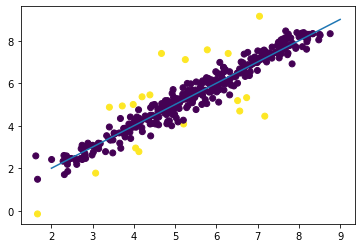

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(dense_predicts_flat, 
            targets, 
            c = np.abs(dense_predicts_flat-targets)>1.,
           )
plt.plot((2,9),(2,9))

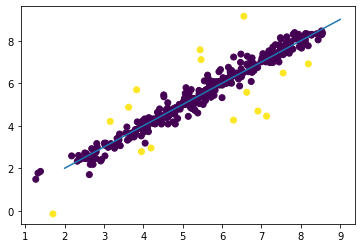

In [152]:
plt.scatter(LS_model_type_predicts_flat, 
            targets, 
            c = np.abs(LS_model_type_predicts_flat-targets)>1.,
           )
plt.plot((2,9),(2,9))

In [155]:
combined_predict_flat = np.average([dense_predicts_flat, LS_model_type_predicts_flat], axis=0)

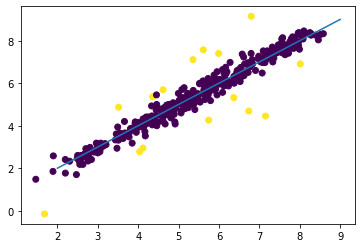

In [157]:
plt.scatter(combined_predict_flat, 
            targets, 
            c = np.abs(combined_predict_flat-targets)>1.,
           )
plt.plot((2,9),(2,9))

In [158]:
r2_score(targets, combined_predict_flat)

0.9367155748872473